# recurrent neural network (RNN)
- NOTE: virtual env: conda activate py310cuda118

In [1]:
import json
import os
from copy import deepcopy
import random

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import torch
import torch.nn as nn

In [2]:
%load_ext autoreload
%autoreload 2
    
torch.manual_seed(1)
    
print(torch.__version__)
print(np.__version__)

2.3.0
1.26.4


In [3]:
device = "cpu"
if torch.cuda.is_available():
    device = "cuda" 
elif torch.backends.mps.is_available():
    device = "mps"
print(f"Using {device} device")

Using cuda device


## dataset

In [4]:
df1 = pd.read_csv('/home/yuan/results/epitope/epitope.txt', sep='\t', header=None, index_col=None)
df2 = pd.read_csv('/home/yuan/results/epitope/other.txt', sep='\t', header=None, index_col=None)
df3 = pd.read_csv('/home/yuan/results/epitope/random.txt', sep='\t', header=None, index_col=None)
# df4 = pd.read_csv('/home/yuan/results/epitope/shuffle.txt', sep='\t', header=None, index_col=None)

In [5]:
# drop duplicates
df11 = df1.drop_duplicates()
print(df1.shape, df11.shape)

df21 = df2.drop_duplicates()
print(df2.shape, df21.shape)

df31 = df3.drop_duplicates()
print(df3.shape, df31.shape)

(1798795, 2) (1798795, 2)
(1384072, 2) (1384072, 2)
(1797574, 2) (1797574, 2)


In [6]:
df = pd.concat([df11, df21, df31])
df = df.sample(frac=1)
print(df.shape)
df.head()

(4980441, 2)


,0,1
162210,SSPADIFAV,other
289781,RQEPSQGTTTFAVTSILRVAA,epitope
949392,RQRDRTGAG,other
1345788,HRPDNLVPPAPQPP,epitope
1179777,CNQFGHEVK,other


In [7]:
from collections import Counter

# train_data = list(df.iloc[:10_000,:].apply(lambda x: (x[1], x[0]), axis=1))
train_data = list(df.apply(lambda x: (x[1], x[0]), axis=1))
print(train_data[0])
counts = Counter([i[0] for i in train_data])
print(counts)

('other', 'SSPADIFAV')
Counter({'epitope': 1798795, 'random': 1797574, 'other': 1384072})


In [32]:
# embedding
from my_embedding import MyEmbedding

me = MyEmbedding(train_data)
train_ds, valid_ds, test_ds = me.split()
a,b = me.tokenize()
input_vocab, label_vocab = me.build_vocab()

example element of data:  ('epitope', 'IGIQTDSQSSLH')
split data:  2988264 996088 996089

## Step 2 tokenization: unique tokens (words)...
A sentence converted to tokens: IRSQDDNTVVIEKRK ['I', 'R', 'S', 'Q', 'D', 'D', 'N', 'T', 'V', 'V', 'I', 'E', 'K', 'R', 'K']
Vocab-size of input: 22
Vocab-size of labels: 3
OrderedDict([('L', 2888693), ('A', 2506679), ('S', 2457697), ('G', 2283819), ('E', 2281359), ('V', 2253165), ('K', 2062681), ('P', 2054941), ('T', 2008983), ('R', 1954255), ('D', 1889338), ('I', 1812417), ('Q', 1716199), ('N', 1622240), ('F', 1584170), ('Y', 1410626), ('H', 1247833), ('M', 1142380), ('C', 1098536), ('W', 967851), ('X', 163), ('U', 51)])
counts of input: [1078970, 1077807, 831487]

## Step 3 encoding: encoding each unique token into integers...


In [57]:
input_vocab

Vocab()

In [ ]:
label_vocab

In [55]:
from my_collate import MyCollate
from my_rnn import MyRnn
from my_process import MyProcess

vocab_size = len(input_vocab)
embedding_dim = 48
model = MyRnn(vocab_size, embedding_dim).to(device)
print(model)

# training model
# update collate_batch
## Step 3-A: define the functions for transformation
# feed a tokens vector representing one sentence 
text_pipeline = lambda x: [input_vocab[token] for token in list(x)]
label_pipeline = lambda x: 1 if x == 'epitope' else 0
collate_fn = MyCollate(text_pipeline, label_pipeline)

MyRnn(
  (embedding): Embedding(26, 48, padding_idx=0)
  (rnn): LSTM(48, 64, num_layers=2, batch_first=True)
  (linear): Sequential(
    (0): Linear(in_features=64, out_features=128, bias=True)
    (1): ReLU()
    (2): Linear(in_features=128, out_features=1, bias=True)
    (3): Sigmoid()
  )
)


In [56]:
# train RNN model

num_epochs = 20
p = MyProcess(model, collate_fn, num_epochs)
trained_model, stat = p.run(train_ds, valid_ds)

Epoch 0 acc: 0.7890; val_acc: 0.8006, val_recall: 0.7786
Epoch 1 acc: 0.8038; val_acc: 0.8058, val_recall: 0.7829
Epoch 2 acc: 0.8085; val_acc: 0.8076, val_recall: 0.7955
Epoch 3 acc: 0.8111; val_acc: 0.8092, val_recall: 0.7859
Epoch 4 acc: 0.8137; val_acc: 0.8117, val_recall: 0.7946
Epoch 5 acc: 0.8158; val_acc: 0.8123, val_recall: 0.7991
Epoch 6 acc: 0.8174; val_acc: 0.8134, val_recall: 0.7961
Epoch 7 acc: 0.8184; val_acc: 0.8134, val_recall: 0.7943
Epoch 8 acc: 0.8195; val_acc: 0.8137, val_recall: 0.7938
Epoch 9 acc: 0.8209; val_acc: 0.8142, val_recall: 0.7930
Epoch 10 acc: 0.8217; val_acc: 0.8147, val_recall: 0.7982
Epoch 11 acc: 0.8224; val_acc: 0.8146, val_recall: 0.7956
Epoch 12 acc: 0.8231; val_acc: 0.8150, val_recall: 0.7984
Epoch 13 acc: 0.8236; val_acc: 0.8149, val_recall: 0.7985
Epoch 14 acc: 0.8239; val_acc: 0.8149, val_recall: 0.7965
Epoch 15 acc: 0.8244; val_acc: 0.8146, val_recall: 0.8000
Epoch 16 acc: 0.8246; val_acc: 0.8148, val_recall: 0.7930
Epoch 17 acc: 0.8253; va

In [58]:
stat

,acc_train,loss_train,acc_valid,loss_valid,rec_valid
0,0.788956,0.443465,0.800556,0.426392,0.778580
1,0.803799,0.419909,0.805813,0.417328,0.782906
2,0.808547,0.411809,0.807593,0.413821,0.795489
3,0.811143,0.407247,0.809203,0.411803,0.785914
4,0.813726,0.402906,0.811666,0.407626,0.794559
5,0.815833,0.399449,0.812312,0.405831,0.799104
6,0.817387,0.396790,0.813407,0.405661,0.796082
7,0.818449,0.395138,0.813443,0.404712,0.794343
8,0.819502,0.393112,0.813719,0.404412,0.793827
9,0.820893,0.391201,0.814207,0.403448,0.792969


In [59]:
# test predict
input = [
    # epitope
    'SSPFLKGFLAGYVVAKLRASAV', 
    # other seq
    'AELMPVGDNN',
    # wrong seq
    'AXAXAXAXA',
]
res = p.predict(input)
res

,text,predict
0,SSPFLKGFLAGYVVAKLRASAV,0.987687
1,AELMPVGDNN,0.125607
2,AXAXAXAXA,0.885124


In [60]:
print(trained_model.embedding)
print(trained_model.embedding.weight.shape)

Embedding(26, 48, padding_idx=0)
torch.Size([26, 48])


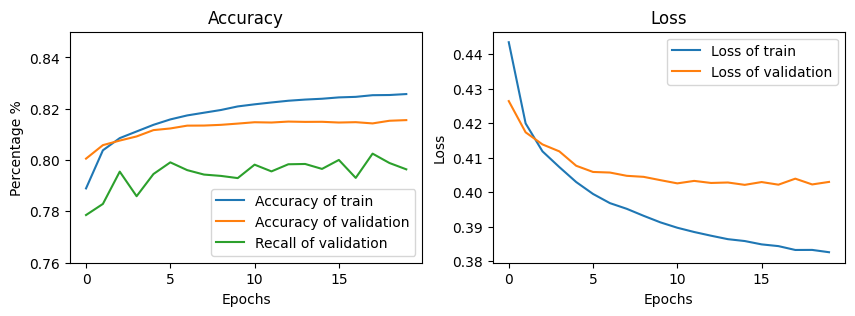

In [61]:
fig = plt.figure(figsize=(10,3))
x_arr = list(range(num_epochs))
ax = fig.add_subplot(1,2,1)
ax.plot(x_arr, stat.acc_train, label="Accuracy of train")
ax.plot(x_arr, stat.acc_valid, label="Accuracy of validation")
ax.plot(x_arr, stat.rec_valid, label="Recall of validation")
ax.legend(fontsize=10)
ax.set_ylim(.76, .85)
ax.set_title('Accuracy')
ax.set_xlabel('Epochs')
ax.set_ylabel('Percentage %')

ax = fig.add_subplot(1,2,2)
ax.plot(x_arr, stat.loss_train, label="Loss of train")
ax.plot(x_arr, stat.loss_valid, label="Loss of validation")
ax.legend(fontsize=10)
ax.set_title('Loss')
ax.set_xlabel('Epochs')
ax.set_ylabel('Loss')

plt.show()

In [62]:
# test model using test data
res = p.test(test_ds)
res

{'recall': 0.7968339124578221,
 'accuracy': 0.8160505737941087,
 'loss': 0.40226693477603437}

In [63]:
# distriubtion of prediction probability using test data
test_X = [i[1] for i in test_ds]
pred_test = p.predict(test_X)
pred_test['labels'] = [i[0] for i in test_ds]
pred_test.head()

,text,predict,labels
0,IDVKYIGVKSAYVSYD,0.977990,epitope
1,LVIVAPDCVTITY,0.158475,random
2,WPSQTVTCSVAHPASS,0.915184,epitope
3,NVKYNGLCYKD,0.066109,random
4,VLSQEIVRLS,0.215938,other


359361 636728


Text(0.5, 1.0, 'Distinguish non-epitopes, n = 636728')

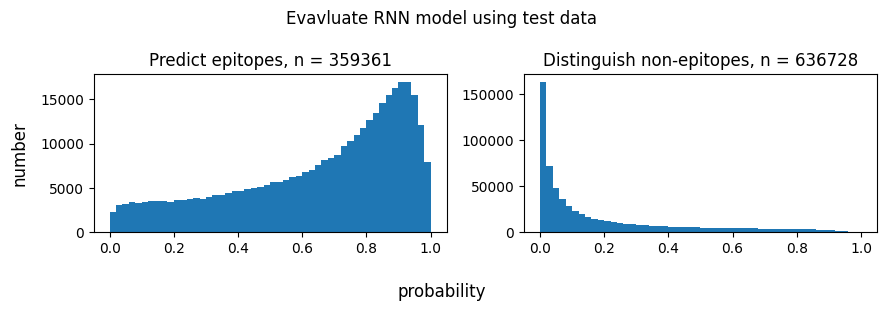

In [64]:
t = pred_test[pred_test['labels']=='epitope']['predict']
f = pred_test[~(pred_test['labels']=='epitope')]['predict']
print(len(t), len(f))

fig, ax = plt.subplots(1, 2, figsize=(9,3), layout='tight')
fig.suptitle('Evavluate RNN model using test data')
fig.supxlabel('probability')
fig.supylabel('number')

ax[0].hist(t, bins=50)
ax[0].set_title(f'Predict epitopes, n = {len(t)}')
ax[1].hist(f, bins=50)
ax[1].set_title(f'Distinguish non-epitopes, n = {len(f)}')

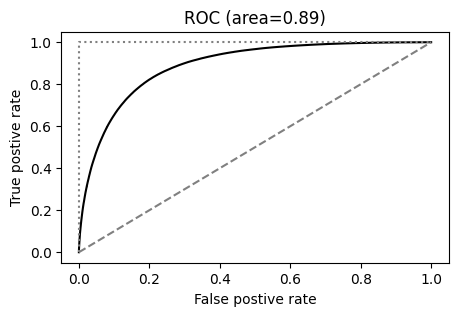

In [65]:
from sklearn.metrics import roc_curve, auc

fpr, tpr, thresholds = roc_curve(pred_test['labels'], pred_test['predict'], pos_label='epitope')
roc_auc = auc(fpr, tpr)
plt.figure(figsize=(5,3))
plt.plot(fpr, tpr, color='black')
plt.title(f'ROC (area={roc_auc:.2f})')
plt.xlabel('False postive rate')
plt.ylabel('True postive rate')
plt.plot([0,1],[0,1], linestyle='--', color='grey')
plt.plot([0,0,1],[0,1,1], linestyle=':', color='grey')

In [71]:
# save model
torch.save(input_vocab, '../models/epitopes_rnn_input_vocab.pth')
torch.save(model.state_dict(), '../models/epitopes_rnn_weights.pth')
torch.save(model, '../models/epitopes_rnn_model.pth')

# test load_model

In [67]:
model0 = torch.load('../models/epitopes_rnn_model.pth')
model0.eval()

MyRnn(
  (embedding): Embedding(26, 48, padding_idx=0)
  (rnn): LSTM(48, 64, num_layers=2, batch_first=True)
  (linear): Sequential(
    (0): Linear(in_features=64, out_features=128, bias=True)
    (1): ReLU()
    (2): Linear(in_features=128, out_features=1, bias=True)
    (3): Sigmoid()
  )
)

In [68]:
from my_process import MyProcess

p0 = MyProcess(model, collate_fn)

In [69]:
input = [
    # epitope
    'SSPFLKGFLAGYVVAKLRASAV', 
    # other seq
    'AELMPVGDNN',
    # wrong seq
    'AXAXAXAXA',
]
pred0 = p.predict(input)
pred0

,text,predict
0,SSPFLKGFLAGYVVAKLRASAV,0.987687
1,AELMPVGDNN,0.125607
2,AXAXAXAXA,0.885124
